<a href="https://colab.research.google.com/github/barauna-lo/Neurocomputing/blob/main/Project_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src=https://raw.githubusercontent.com/barauna-lo/CAP4213-Deep-Learning/main/logoinpe.png align=”middle”>](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/barauna-lo/Deep-Learning/blob/main/LogoCAP.png?raw=true" width = 450 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


# Project 01 - Multi-layer Perceptron (MLP)

* [Luan Orion Baraúna](https://www.linkedin.com/in/luan-orion-barauna/)


## PROJETO 1 – REDE MLP

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:

  * Diferentes topologias (>=5 topologias, variar número de
camadas

  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  
  * Avaliar o impacto do uso do Momentum

  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import math
import pandas as pd
import time # for time mesurment

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

print(tf.__version__)

2.8.2


## Dataset

This dataset refers to the PSD of the two-point correlation function of the Cosmic Background Radiation and is of great importance for the determination of the cosmological parameters.

This data set can be found at 
http://pla.esac.esa.int/pla/#cosmology



In [2]:
!wget "http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt"

--2022-07-12 22:42:42--  http://pla.esac.esa.int/pla/aio/product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt
Resolving pla.esac.esa.int (pla.esac.esa.int)... 193.147.153.153
Connecting to pla.esac.esa.int (pla.esac.esa.int)|193.147.153.153|:80... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/x-binary]
Saving to: ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt’

product-action?COSM     [    <=>             ] 166.55K   220KB/s    in 0.8s    

2022-07-12 22:42:43 (220 KB/s) - ‘product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt’ saved [170547]



In [3]:
df = pd.read_fwf('product-action?COSMOLOGY.FILE_ID=COM_PowerSpect_CMB-TT-full_R3.01.txt')
df.columns = ["id","l", "Dl", "+dDl", "-dDl"]
df.drop('id', axis=1, inplace=True)

In [7]:
#Normalize data
#https://towardsdatascience.com/why-data-should-be-normalized-before-training-a-neural-network-c626b7f66c7d
df.l =  (df.l - df.l.mean()) / df.l.std()
df.Dl =  (df.Dl - df.Dl.mean()) / df.Dl.std()
df['+dDl'] =  (df['+dDl'] - df['+dDl'].mean()) / df['+dDl'].std()
df['+dDl'] =  (df['-dDl'] - df['-dDl'].mean()) / df['-dDl'].std()

$$ D_l = \frac{l(l+1)Cl}{(2\pi)} $$

[]

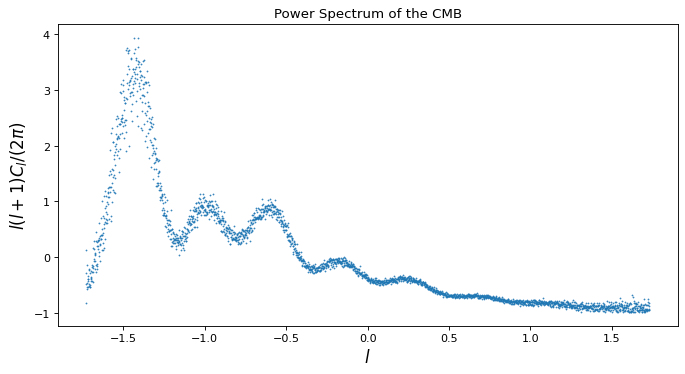

In [9]:
#from IPython.core.pylabtools import figsize
figure(figsize=(10,5),dpi=80)
plt.scatter(df.l,df.Dl,s=0.3)
#plt.errorbar(l, Dl, df.min_error, df.max_error, fmt='r^')
#plt.xscale('log')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.title("Power Spectrum of the CMB")
plt.plot()


In [12]:
df.Dl.mean()

0.0

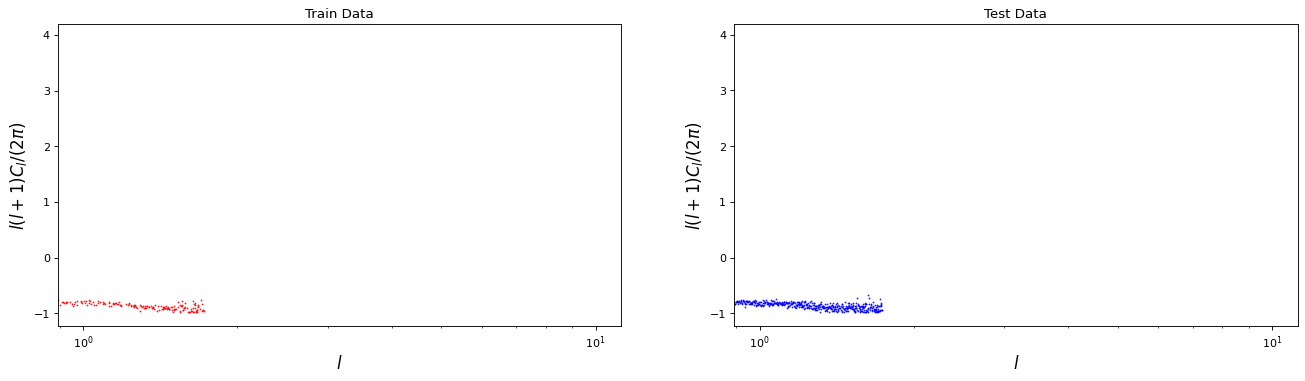

In [13]:
# Spliting in traing and Validation 
x_train, x_test, y_train, y_test = train_test_split(df.l, df.Dl, test_size=0.7)
# print(len(x_train))
# print(len(x_test))
figure(figsize=(20,5),dpi=80)

plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color='red',s=0.3)
plt.title('Train Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.xscale('log')

plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color='blue',s=0.3)
plt.title('Test Data')
plt.xlabel(r'$l$',size=15)
plt.ylabel(r'$l(l+1)C_l/(2\pi)$',size=15)
plt.xscale('log')
plt.show()


## Modelos 1

To attempt to build a network capable of finding a regression law for these problems, we will generate 5 different network topologies. The first will be the simple and classic case of a perceptron and the second will increase the number of layers and the number of neurons.

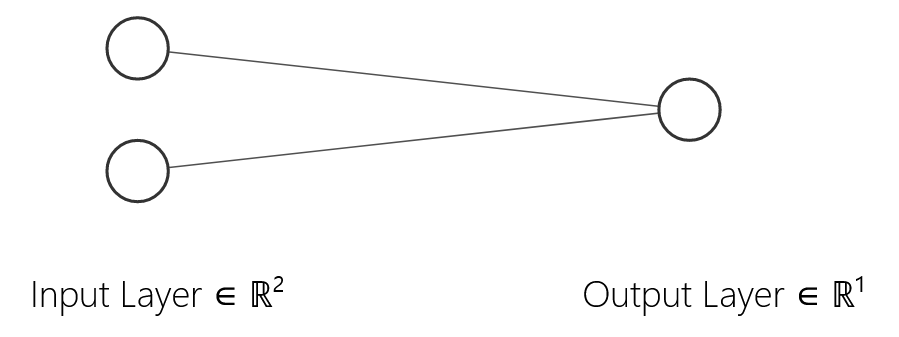

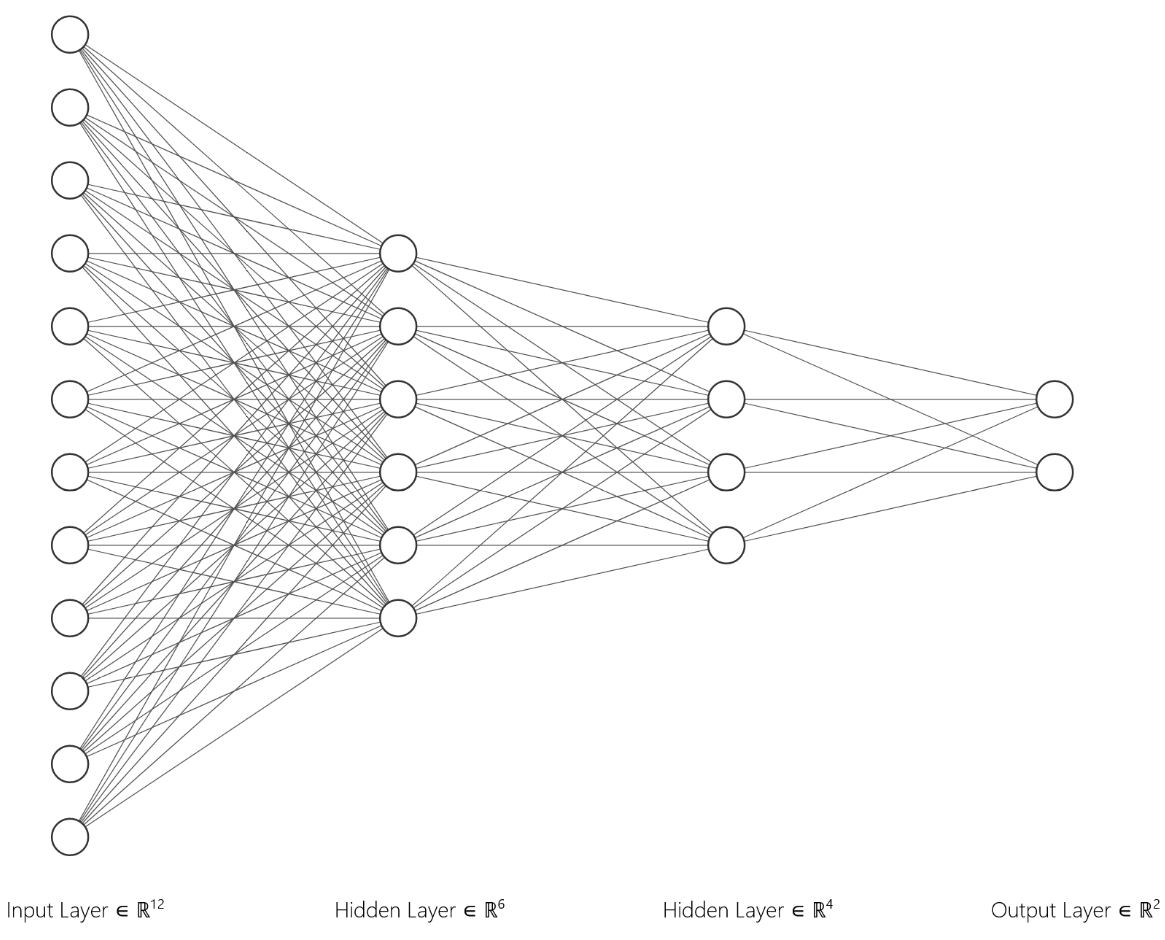

In [14]:
#Paramentes
fl2 = 0.0
drop = 0.2
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
adam = tf.keras.optimizers.Adam()

#Model_01 -- Simple Case
model_01 = keras.Sequential()
model_01.add(keras.layers.Dense(units=3, input_shape=[1], activation="tanh"))
model_01.add(keras.layers.Dense(units=1, activation="linear"))
model_01.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])
#tf.keras.utils.plot_model(model_01, show_shapes=True)

#Model_02
model_02 = keras.Sequential()
model_02.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
model_02.add(keras.layers.Dense(units=5, activation="tanh"))
model_02.add(keras.layers.Dense(units=1, activation="linear"))
model_02.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#Model_03
model_03 = keras.Sequential()
model_03.add(keras.layers.Dense(units=5, input_shape=[1], activation="tanh"))
model_03.add(keras.layers.Dense(units=5, activation="tanh"))
model_03.add(keras.layers.Dense(units=1, activation="linear"))
model_03.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])


#Model_x - Supose to be the last and more powerfull model
model_x = keras.Sequential()
model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
model_x.add(Dropout(drop))
model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
model_x.add(Dropout(drop))
model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
model_x.add(Dropout(drop))
model_x.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), activation="tanh"))
model_x.add(Dropout(drop))
model_x.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
model_x.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="sigmoid"))
model_x.add(keras.layers.Dense(units=50, activation="linear"))

In [16]:
# COMPILATION 📦

model_01.compile(loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])
model_x.compile( loss='mean_squared_error', optimizer=adam, metrics=["mean_absolute_error"])

#tf.keras.utils.plot_model(model_x, show_shapes=True)

## Treino

In [17]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

#Traing Model_01
start_time_01 = time.time()
history_01 = model_01.fit(x_train, y_train, epochs=3000, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_01 = time.time()



#Traing Model_01
start_time_x = time.time()
history_x = model_x.fit(x_train, y_train, epochs=3000, batch_size=10, validation_split=0.2, verbose=1)#, 
end_time_x = time.time()
# print("Network parameters: {}".format(model.get_weights()))



A saída de streaming foi truncada nas últimas 5000 linhas.
61/61 [==============================] - 0s 8ms/step - loss: 0.0461 - mean_absolute_error: 0.1428 - val_loss: 0.0600 - val_mean_absolute_error: 0.1535
Epoch 502/3000
61/61 [==============================] - 0s 7ms/step - loss: 0.0576 - mean_absolute_error: 0.1569 - val_loss: 0.0727 - val_mean_absolute_error: 0.1537
Epoch 503/3000
61/61 [==============================] - 0s 7ms/step - loss: 0.0541 - mean_absolute_error: 0.1539 - val_loss: 0.0444 - val_mean_absolute_error: 0.1369
Epoch 504/3000
61/61 [==============================] - 0s 7ms/step - loss: 0.1089 - mean_absolute_error: 0.1899 - val_loss: 0.1304 - val_mean_absolute_error: 0.1837
Epoch 505/3000
61/61 [==============================] - 0s 7ms/step - loss: 0.0641 - mean_absolute_error: 0.1624 - val_loss: 0.0533 - val_mean_absolute_error: 0.1339
Epoch 506/3000
61/61 [==============================] - 0s 8ms/step - loss: 0.0679 - mean_absolute_error: 0.1598 - val_loss: 0

In [18]:
print(end_time_01 - start_time_01)
print(end_time_x - start_time_x)

622.3180029392242
1403.27498960495


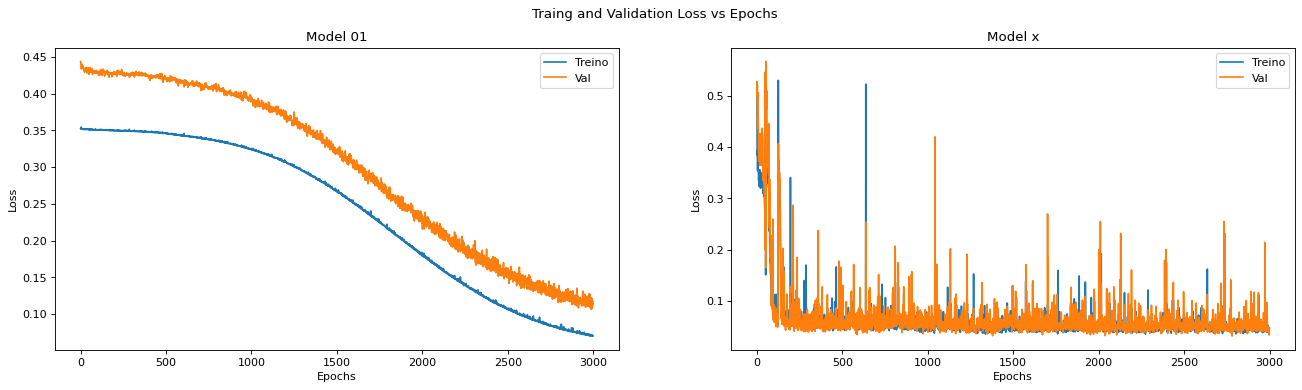

In [19]:
figure(figsize=(20,5),dpi=80)
plt.suptitle("Traing and Validation Loss vs Epochs")
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_01.history['loss'], label="Treino")
plt.plot(history_01.history['val_loss'], label="Val")
plt.title('Model 01')
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history_x.history['loss'], label="Treino")
plt.plot(history_x.history['val_loss'], label="Val")
plt.title('Model x')
plt.legend()

plt.show()

# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.plot(history_1.history['loss'][-100:], label="Treino")
# plt.plot(history_1.history['val_loss'][-100:], label="Val")
# plt.legend()
# plt.show()

# Avaliação (teste)

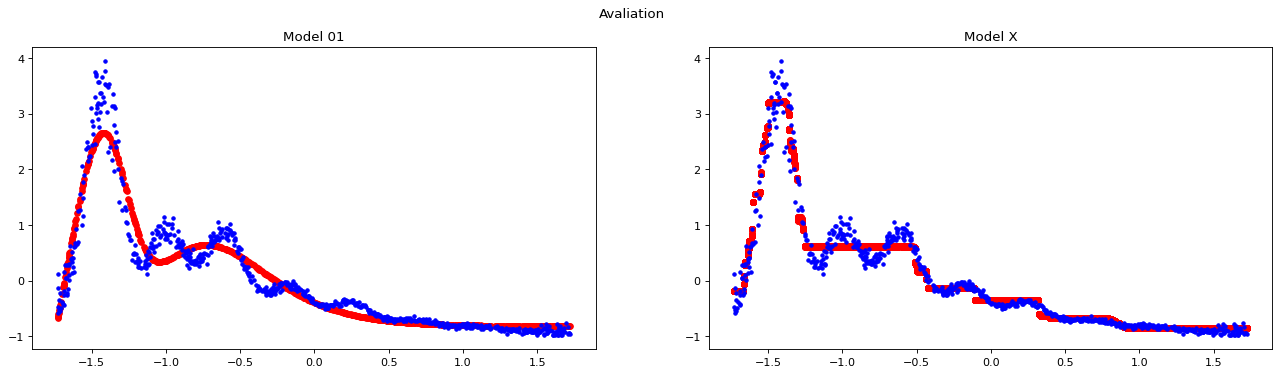

In [22]:
figure(figsize=(20,5),dpi=80)
plt.suptitle('Avaliation')
plt.subplot(1,2,1)
y_rest = model_01.predict(x_train)
plt.plot(x_train, y_rest, '.', markersize=10 ,color='red')
plt.plot(x_train, y_train, '.', color='blue')
plt.title('Model 01')
#plt.xscale('log')

plt.subplot(1,2,2)
y_rest = model_x.predict(x_train)
plt.plot(x_train, y_rest, '.', markersize=10 ,color='red')
plt.plot(x_train, y_train, '.', color='blue')
plt.title('Model X')
#plt.xscale('log')

plt.show()

In [21]:
score_01 = model_01.evaluate(x_test, y_test, verbose=0)
score_x = model_x.evaluate(x_test, y_test, verbose=0)
print("Model 01")
print("Test loss:", score_01[0])
print("Test metric:", score_01[1],'\n')
print("Model x")
print("Test loss:", score_x[0])
print("Test metric:", score_x[1])

Model 01
Test loss: 0.06466995924711227
Test metric: 0.17415091395378113 

Model x
Test loss: 0.0349133275449276
Test metric: 0.12154144048690796


## Keras Functional